# Programe sua GPU com OpenMP

Autores: 
_Hermes Senger_ e
_Jaime Freire de Souza_

## Configuração do ambiente

Precisaremos de um compilador capaz de gerar código executável para GPUs. 


In [1]:
%%shell
ln -sfnv /usr/local/cuda-10.1/ /usr/local/cuda
pip install -q matplotlib numpy
wget https://openmp-course.s3.amazonaws.com/llvm.tar.gz
tar -xzvf llvm.tar.gz >/dev/null 2>&1
#echo "  ------------  Terminou a instalação! Pode continuar  ------------------"

'/usr/local/cuda' -> '/usr/local/cuda-10.1/'
--2022-04-18 02:27:55--  https://openmp-course.s3.amazonaws.com/llvm.tar.gz
Resolving openmp-course.s3.amazonaws.com (openmp-course.s3.amazonaws.com)... 52.217.66.236
Connecting to openmp-course.s3.amazonaws.com (openmp-course.s3.amazonaws.com)|52.217.66.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 810538565 (773M) [application/x-gzip]
Saving to: ‘llvm.tar.gz’

llvm.tar.gz         100%[===================>] 772.99M  63.5MB/s    in 12s     

2022-04-18 02:28:07 (66.0 MB/s) - ‘llvm.tar.gz’ saved [810538565/810538565]



In [2]:
import os

os.environ['LLVM_PATH'] = '/content/llvm'
os.environ['PATH'] = os.environ['LLVM_PATH'] + '/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = os.environ['LLVM_PATH'] + '/lib:' + os.environ['LD_LIBRARY_PATH']
os.environ['TSAN_OPTIONS'] = 'ignore_noninstrumented_modules=1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot():

    # read the input (wavefield N x M) file
    input = np.loadtxt('wavefield/wavefield.txt')

    # process data e generate the plot
    plt.imshow(input)
    plt.show()

## Exemplo 1 - Modelagem da onda acústica

Ondas acústicas são utilizadas para resolver vários problemas em engenharia, medicina, geofísica e etc. A propagação de uma onda acústica pode ser modelada pela equação diferencial abaixo:

$$     \frac{1}{v^2_p}\frac{\partial^2p({\bf x},t)}{\partial t^2} - \nabla^2 p({\bf x},t) = f({\bf x},t)
        \label{acoustic_iso}$$ 

onde $v_p$ é a velocidade da onda de pressão, $p({\bf x},t)$ representa a pressão em um ponto $x$ em um instante $t$ (sendo que as coordenadas no espaço podem ser expandidos para 2 ou 3 dimensões) e $f({\bf x},t)$ é a fonte do sinal. Para resolvermos de forma numérica (isto é, em um computador), vamos precisar da equação na sua forma discretizada (neste caso, em 2 dimensões):

$$ p^{n+1}_{i,j} = 2p^{n}_{i,j} - p^{n-1}_{i,j} + 2\Delta t^2 .  v^2 \Big( \frac{p^{n}_{i+1,j} - 2p^{n}_{i,j} + p^{n}_{i-1,j}} {\Delta x^2} +  \frac{p^{n}_{i,j+1} - 2p^{n}_{i,j} + p^{n}_{i,j-1}} {\Delta y^2} \Big)
\label{eq:acoustic_iso_discrete} $$

onde $p^{n}_{i,j}$ representa um ponto $p$ nas coordenadas ${i,j}$ no instante ($n$). Este é um padrão chamado de _estêncil_, onde cada ponto da matriz é calculado em função dos seus vizinhos. 
<figure>
  <img src="stencil-2d.png" alt="Trulli" style="width:25%">
</figure>

Felizmente, todos os pontos podem ser calculados simultaneamente (ou seja, em paralelo) seguindo os seguintes passos:

- A cada iteração é feita a cópia dos dados (prev_u, next_u, vel_model) da memória do host para o memória da GPU.
- O loop do grid (matriz que representa do espaço de propagação da onda) é executado na GPU.
- Ao final da iteração, é feita a cópia dos dados (prev_u, next_u) da memória da GPU para a memória do host.

## Equação da onda V1.0: 

Por fazer a cópia dos dados a cada nova iteração, essa solução não é eficiente.


In [4]:
%%writefile wave_1.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");      

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);    

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);   

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");    

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }    

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");   

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;    

    // get the start time
    double start_time = omp_get_wtime();    
    

    // wavefield modeling        
    for(size_t n = 0; n < iterations; n++) {
        
        #pragma omp target map(tofrom: prev_u[:(nz * nx)], next_u[:(nz * nx)]) \
                           map(to: vel_model[:(nz * nx)])
        #pragma omp teams distribute parallel for
        for(size_t i = 1; i < nz - 1; i++) {
            for(size_t j = 1; j < nx - 1; j++) {
                // index of the current point in the grid
                size_t current = i * nx + j;                

                //neighbors in the horizontal direction
                double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                //neighbors in the vertical direction
                value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;                

                value *= dtSquared * vel_model[current] * vel_model[current];
                next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;        
    }    

    double exec_time = omp_get_wtime() - start_time;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Writing wave_1.c


In [7]:
!clang -O3 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda -Xopenmp-target -march=sm_37 wave_1.c -o wave_1

In [8]:
!./wave_1 1024 1024 1000

Grid Sizes: 1024 x 1024
Iterations: 1000
Initializing ... 
Computing wavefield ... 
Iterations completed in 13.158103 seconds 


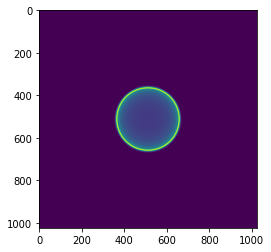

In [9]:
plot()

### Exemplo 2 - Propagação da onda acústica

Esse exemplo apresenta uma otimização em relação ao exemplo anterior:

- Inicialmente é feita a cópia dos dados da memória da CPU para a memória da GPU, apenas uma vez.
- O loop do grid é executado na GPU a cada nova iteração temporal.
- Ao final de todas as iterações temporais, apenas o vetor next_u é capiado de volta para a memória da CPU, pois armazena do campo de onda final.


In [10]:
%%writefile wave_2.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");      

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);    

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);   

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");    

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }    

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");   

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;    

    // get the start time
    double start_time = omp_get_wtime();
    
    #pragma omp target enter data map(to: prev_u[:(nz * nx)])
    #pragma omp target enter data map(to: next_u[:(nz * nx)])
    #pragma omp target enter data map(to: vel_model[:(nz * nx)])

    // wavefield modeling
    for(size_t n = 0; n < iterations; n++) {

        #pragma omp target teams distribute parallel for
        for(size_t i = 1; i < nz - 1; i++) {
            for(size_t j = 1; j < nx - 1; j++) {
                // index of the current point in the grid
                size_t current = i * nx + j;                

                //neighbors in the horizontal direction
                double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                //neighbors in the vertical direction
                value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;                

                value *= dtSquared * vel_model[current] * vel_model[current];
                next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;        
    }

    #pragma omp target exit data map(from: next_u[:(nz * nx)])    

    double exec_time = omp_get_wtime() - start_time;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Writing wave_2.c


In [11]:
!clang -O3 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda -Xopenmp-target -march=sm_37 wave_2.c -o wave_2

In [12]:
!./wave_2 1024 1024 1000

Grid Sizes: 1024 x 1024
Iterations: 1000
Initializing ... 
Computing wavefield ... 
Iterations completed in 5.058884 seconds 


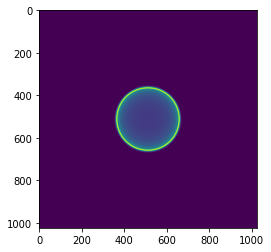

In [13]:
plot()

### Exemplo 3 - Propagação da onda acústica

Esse exemplo adicona a diretiva collapse(2) no loop aninhado que percorre o grid. Essa otimização aumenta a quantidade de threads de trabalho a serem executadas na GPU.

In [14]:
%%writefile wave_3.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");      

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);    

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);   

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");    

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }    

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");   

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;    

    // get the start time
    double start_time = omp_get_wtime();
    
    #pragma omp target enter data map(to: prev_u[:(nz * nx)])
    #pragma omp target enter data map(to: next_u[:(nz * nx)])
    #pragma omp target enter data map(to: vel_model[:(nz * nx)])

    // wavefield modeling
    for(size_t n = 0; n < iterations; n++) {

        #pragma omp target teams distribute parallel for collapse(2)
        for(size_t i = 1; i < nz - 1; i++) {
            for(size_t j = 1; j < nx - 1; j++) {
  
                // index of the current point in the grid
                size_t current = i * nx + j;                

                //neighbors in the horizontal direction
                double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                //neighbors in the vertical direction
                value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;                

                value *= dtSquared * vel_model[current] * vel_model[current];
                next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;        
    }

    #pragma omp target exit data map(from: next_u[:(nz * nx)])    

    double exec_time = omp_get_wtime() - start_time;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Writing wave_3.c


In [15]:
!clang -O3 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda -Xopenmp-target -march=sm_37 wave_3.c -o wave_3

In [16]:
!./wave_3 1024 1024 1000

Grid Sizes: 1024 x 1024
Iterations: 1000
Initializing ... 
Computing wavefield ... 
Iterations completed in 0.642529 seconds 


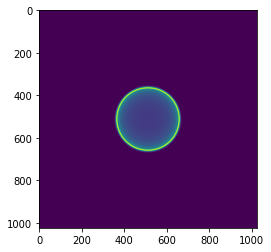

In [17]:
plot()

### Exemplo 4 - Propagação da onda acústica

Adiciona loop tiling.

In [18]:
%%writefile wave_4.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define MIN(x, y) (((x) < (y)) ? (x) : (y))

#define DT 0.002f // delta t
#define DZ 20.0f // delta z
#define DX 20.0f // delta x
#define V 1500.0f // wave velocity v = 1500 m/s

//save the matrix on a file.txt
void save_grid(size_t nz, size_t nx, double *grid){

    system("mkdir -p wavefield");      

    char file_name[32];
    sprintf(file_name, "wavefield/wavefield.txt");

    // save the result
    FILE *file;
    file = fopen(file_name, "w");

    for(size_t i = 1; i < nz - 1; i++) {

        size_t offset = i * nx;

        for(size_t j = 1; j < nx - 1; j++) {
            fprintf(file, "%f ", grid[offset + j]);
        }
        fprintf(file, "\n");
    }

    fclose(file);
}

int main(int argc, char* argv[]) {

    // validate the parameters
    if(argc != 4){
        printf("Usage: ./stencil N1 N2 ITERATIONS\n");
        printf("N1 N2: grid sizes for the stencil\n");
        printf("ITERATIONS: number of timesteps\n");
        exit(-1);
    }

    // number of rows of the grid
    size_t nz = atoi(argv[1]);

    // number of columns of the grid
    size_t nx = atoi(argv[2]);

    // number of timesteps
    size_t iterations = atoi(argv[3]);    

    printf("Grid Sizes: %ld x %ld\n", nz, nx);
    printf("Iterations: %ld\n", iterations);   

    // add the spatial order (halo zone) to the grid size
    nz += 2;
    nx += 2;

    // represent the matrix of wavefield as an array
    double *prev_u = (double*) malloc(nz * nx * sizeof(double));
    double *next_u = (double*) malloc(nz * nx * sizeof(double));

    // represent the matrix of velocities as an array
    double *vel_model = (double*) malloc(nz * nx * sizeof(double));

    // ************* BEGIN INITIALIZATION *************

    printf("Initializing ... \n");    

    // initialize matrix
    for(size_t i = 0; i < nz; i++){

        size_t offset = i * nx;

        for(size_t j = 0; j < nx; j++){
            prev_u[offset + j] = 0.0;
            next_u[offset + j] = 0.0;
            vel_model[offset + j] = V;
        }
    }    

    // add a source to initial wavefield as an initial condition
    double val = 1.f;
    for(int s = 4; s >= 0; s--){
        for(size_t i = nz / 2 - s; i < nz / 2 + s; i++){

            size_t offset = i * nx;

            for(size_t j = nx / 2 - s; j < nx / 2 + s; j++)
                prev_u[offset + j] = val;
        }
        val *= 0.9;
    }

    // ************** END INITIALIZATION **************

    printf("Computing wavefield ... \n");   

    double dzSquared = DZ * DZ;
    double dxSquared = DX * DX;
    double dtSquared = DT * DT;    

    // get the start time
    double start_time = omp_get_wtime();
    
    #pragma omp target enter data map(to: prev_u[:(nz * nx)])
    #pragma omp target enter data map(to: next_u[:(nz * nx)])
    #pragma omp target enter data map(to: vel_model[:(nz * nx)])

    // wavefield modeling
    for(size_t n = 0; n < iterations; n++) {
        
        size_t block_size_z = 8;
        
        size_t block_size_x = 4;

        #pragma omp target teams distribute parallel for collapse(2)        
        for (size_t ii = 1; ii < nz - 1; ii += block_size_z){            
            for (size_t jj = 1; jj < nx - 1; jj += block_size_x){
                for (size_t i = ii; i < MIN(ii+block_size_z, nz - 1); i++) {
                    for (size_t j = jj; j < MIN(jj+block_size_x, nx - 1); j++) {            
       
                        // index of the current point in the grid
                        size_t current = i * nx + j;                

                        //neighbors in the horizontal direction
                        double value = (prev_u[current + 1] - 2.0 * prev_u[current] + prev_u[current - 1]) / dxSquared;
                        //neighbors in the vertical direction
                        value += (prev_u[current + nx] - 2.0 * prev_u[current] + prev_u[current - nx]) / dzSquared;                

                        value *= dtSquared * vel_model[current] * vel_model[current];
                        next_u[current] = 2.0 * prev_u[current] - next_u[current] + value;
                    }
                }
            }
        }

        // swap arrays for next iteration
        double *swap = next_u;
        next_u = prev_u;
        prev_u = swap;        
    }

    #pragma omp target exit data map(from: next_u[:(nz * nx)])    

    double exec_time = omp_get_wtime() - start_time;

    save_grid(nz, nx, next_u);

    printf("Iterations completed in %f seconds \n", exec_time);

    free(prev_u);
    free(next_u);
    free(vel_model);

    return 0;
}

Writing wave_4.c


In [19]:
!clang -O3 -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda -Xopenmp-target -march=sm_37 wave_4.c -o wave_4

In [ ]:
!./wave_4 1024 1024 1000

Grid Sizes: 1024 x 1024
Iterations: 1000
Initializing ... 
Computing wavefield ... 
Iterations completed in 0.577318 seconds 


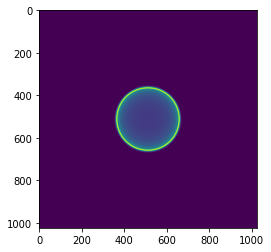

In [20]:
plot()